# ЛР 3 Реализация алгоритма обратного распространения ошибки

## Жуйков Алексей Валерианович ИВТ 1.2


## Цель работы
Получение практических навыков реализации и обучения полносвязной нейронной сети с нуля на языке Python с использованием объектно-ориентированного подхода. Реализация алгоритма обратного распространения ошибки (backpropagation) с применением градиентного спуска на минибатчах для обучения сети на задаче бинарной классификации.

## Основные задачи
1. Реализовать класс NeuralNetwork с полным функционалом
2. Реализовать функции активации (Sigmoid, ReLU, Tanh) и их производные
3. Реализовать прямое и обратное распространение
4. Реализовать обучение с использованием мини-батчей
5. Протестировать на синтетических данных make_moons

In [ ]:
# Импорт необходимых библиотек
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Настройка matplotlib для отображения графиков
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 12


In [ ]:
# Функции активации и их производные
def sigmoid(z):
    """Сигмоидная функция активации"""
    z = np.clip(z, -250, 250)  # Предотвращаем переполнение
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    """Производная сигмоидной функции"""
    s = sigmoid(z)
    return s * (1 - s)

def relu(z):
    """ReLU функция активации"""
    return np.maximum(0, z)

def relu_derivative(z):
    """Производная ReLU функции"""
    return (z > 0).astype(float)

def tanh(z):
    """Гиперболический тангенс"""
    return np.tanh(z)

def tanh_derivative(z):
    """Производная гиперболического тангенса"""
    return 1 - np.tanh(z) ** 2

# Словари для удобного доступа к функциям
activation_functions = {
    'sigmoid': sigmoid,
    'relu': relu,
    'tanh': tanh
}

activation_derivatives = {
    'sigmoid': sigmoid_derivative,
    'relu': relu_derivative,
    'tanh': tanh_derivative
}


In [ ]:
class NeuralNetwork:
    def __init__(self, layer_sizes, activation='relu', learning_rate=0.01, random_state=42):
        """
        Инициализация нейронной сети

        Parameters:
        layer_sizes: список размеров слоев [input_size, hidden1_size, hidden2_size, ..., output_size]
        activation: функция активации для скрытых слоев ('relu', 'sigmoid', 'tanh')
        learning_rate: скорость обучения
        random_state: для воспроизводимости результатов
        """
        np.random.seed(random_state)

        self.layer_sizes = layer_sizes
        self.activation = activation
        self.learning_rate = learning_rate
        self.num_layers = len(layer_sizes)

        # Инициализация параметров сети
        self.parameters = self._initialize_parameters()

        # История обучения
        self.cost_history = []

    def _initialize_parameters(self):
        """
        Инициализация весов и смещений сети
        Используется Xavier инициализация для весов
        """
        parameters = {}

        for l in range(1, self.num_layers):
            # Xavier инициализация
            parameters[f'W{l}'] = np.random.randn(self.layer_sizes[l], self.layer_sizes[l-1]) * np.sqrt(1 / self.layer_sizes[l-1])
            parameters[f'b{l}'] = np.zeros((self.layer_sizes[l], 1))

        return parameters

    def _forward(self, X):
        """
        Прямое распространение сигнала через сеть

        Parameters:
        X: входные данные размерности (n_features, m_examples)

        Returns:
        A_last: выходные активации последнего слоя
        cache: словарь с промежуточными значениями Z и A для каждого слоя
        """
        cache = {}
        A = X
        cache['A0'] = A

        # --- НАЧАЛО ВАШЕГО КОДА ---
        # Проход через все слои сети
        for l in range(1, self.num_layers):
            A_prev = A

            # Линейная трансформация: Z = W*A + b
            Z = np.dot(self.parameters[f'W{l}'], A_prev) + self.parameters[f'b{l}']

            # Применение функции активации
            if l == self.num_layers - 1:  # Выходной слой - всегда сигмоид для бинарной классификации
                A = sigmoid(Z)
            else:  # Скрытые слои
                A = activation_functions[self.activation](Z)

            # Сохраняем промежуточные значения
            cache[f'Z{l}'] = Z
            cache[f'A{l}'] = A
        # --- КОНЕЦ ВАШЕГО КОДА ---

        return A, cache

    def _compute_cost(self, A_last, Y):
        """
        Вычисление функции потерь (бинарная перекрестная энтропия)

        Parameters:
        A_last: выходные активации сети размерности (1, m)
        Y: истинные метки размерности (1, m)

        Returns:
        cost: значение функции потерь
        """
        m = Y.shape[1]

        # --- НАЧАЛО ВАШЕГО КОДА ---
        # Предотвращаем log(0) добавляя небольшое значение epsilon
        epsilon = 1e-15
        A_last = np.clip(A_last, epsilon, 1 - epsilon)

        # Бинарная перекрестная энтропия
        cost = -1/m * np.sum(Y * np.log(A_last) + (1 - Y) * np.log(1 - A_last))
        # --- КОНЕЦ ВАШЕГО КОДА ---

        return cost

    def _backward(self, A_last, Y, cache):
        """
        Обратное распространение ошибки

        Parameters:
        A_last: выходные активации сети
        Y: истинные метки
        cache: промежуточные значения из прямого прохода

        Returns:
        grads: словарь с градиентами по всем параметрам
        """
        grads = {}
        m = A_last.shape[1]

        # --- НАЧАЛО ВАШЕГО КОДА ---
        # Градиенты для выходного слоя L
        L = self.num_layers - 1

        # dZ для выходного слоя (производная функции потерь по Z_L)
        dZ = A_last - Y

        # Градиенты для выходного слоя
        grads[f'dW{L}'] = 1/m * np.dot(dZ, cache[f'A{L-1}'].T)
        grads[f'db{L}'] = 1/m * np.sum(dZ, axis=1, keepdims=True)
        grads[f'dA{L-1}'] = np.dot(self.parameters[f'W{L}'].T, dZ)

        # Обратное распространение через скрытые слои
        for l in reversed(range(1, L)):
            # Вычисляем dZ для текущего слоя
            dA = grads[f'dA{l}']
            dZ = dA * activation_derivatives[self.activation](cache[f'Z{l}'])

            # Градиенты для текущего слоя
            grads[f'dW{l}'] = 1/m * np.dot(dZ, cache[f'A{l-1}'].T)
            grads[f'db{l}'] = 1/m * np.sum(dZ, axis=1, keepdims=True)

            if l > 1:  # Если не первый слой
                grads[f'dA{l-1}'] = np.dot(self.parameters[f'W{l}'].T, dZ)
        # --- КОНЕЦ ВАШЕГО КОДА ---

        return grads

    def _update_parameters(self, grads):
        """
        Обновление параметров сети на основе градиентов

        Parameters:
        grads: словарь с градиентами
        """
        # --- НАЧАЛО ВАШЕГО КОДА ---
        for l in range(1, self.num_layers):
            self.parameters[f'W{l}'] = self.parameters[f'W{l}'] - self.learning_rate * grads[f'dW{l}']
            self.parameters[f'b{l}'] = self.parameters[f'b{l}'] - self.learning_rate * grads[f'db{l}']
        # --- КОНЕЦ ВАШЕГО КОДА ---

    def fit(self, X_train, Y_train, epochs=1000, batch_size=32, print_cost=True, print_every=100):
        """
        Обучение нейронной сети

        Parameters:
        X_train: обучающие данные размерности (n_features, m_examples)
        Y_train: метки размерности (1, m_examples)
        epochs: количество эпох обучения
        batch_size: размер мини-батча
        print_cost: печатать ли значение функции потерь
        print_every: как часто печатать значение функции потерь
        """
        m = X_train.shape[1]
        self.cost_history = []

        for epoch in range(epochs):
            epoch_cost = 0
            num_batches = 0

            # --- НАЧАЛО ВАШЕГО КОДА ---
            # Перемешивание данных
            indices = np.random.permutation(m)
            X_shuffled = X_train[:, indices]
            Y_shuffled = Y_train[:, indices]

            # Обучение на мини-батчах
            for i in range(0, m, batch_size):
                # Получение мини-батча
                end_idx = min(i + batch_size, m)
                X_batch = X_shuffled[:, i:end_idx]
                Y_batch = Y_shuffled[:, i:end_idx]

                # Прямое распространение
                A_last, cache = self._forward(X_batch)

                # Вычисление функции потерь
                cost = self._compute_cost(A_last, Y_batch)
                epoch_cost += cost
                num_batches += 1

                # Обратное распространение
                grads = self._backward(A_last, Y_batch, cache)

                # Обновление параметров
                self._update_parameters(grads)
            # --- КОНЕЦ ВАШЕГО КОДА ---

            # Средняя стоимость за эпоху
            avg_cost = epoch_cost / num_batches
            self.cost_history.append(avg_cost)

            # Печать прогресса
            if print_cost and epoch % print_every == 0:
                print(f"Эпоха {epoch}/{epochs}, Средняя функция потерь: {avg_cost:.6f}")

    def predict(self, X):
        """
        Предсказание для новых данных

        Parameters:
        X: данные для предсказания размерности (n_features, m_examples)

        Returns:
        predictions: бинарные предсказания (0 или 1)
        probabilities: вероятности класса 1
        """
        # --- НАЧАЛО ВАШЕГО КОДА ---
        # Прямое распространение
        A_last, _ = self._forward(X)

        # Преобразование вероятностей в бинарные предсказания
        predictions = (A_last > 0.5).astype(int)
        probabilities = A_last
        # --- КОНЕЦ ВАШЕГО КОДА ---

        return predictions, probabilities

    def accuracy(self, X, Y):
        """
        Вычисление точности предсказаний
        """
        predictions, _ = self.predict(X)
        return np.mean(predictions == Y) * 100

print("Класс NeuralNetwork определен успешно!")

Класс NeuralNetwork определен успешно!


Форма X: (2, 300)
Форма y: (1, 300)
Количество примеров: 300
Количество признаков: 2
Уникальные классы: [0 1]


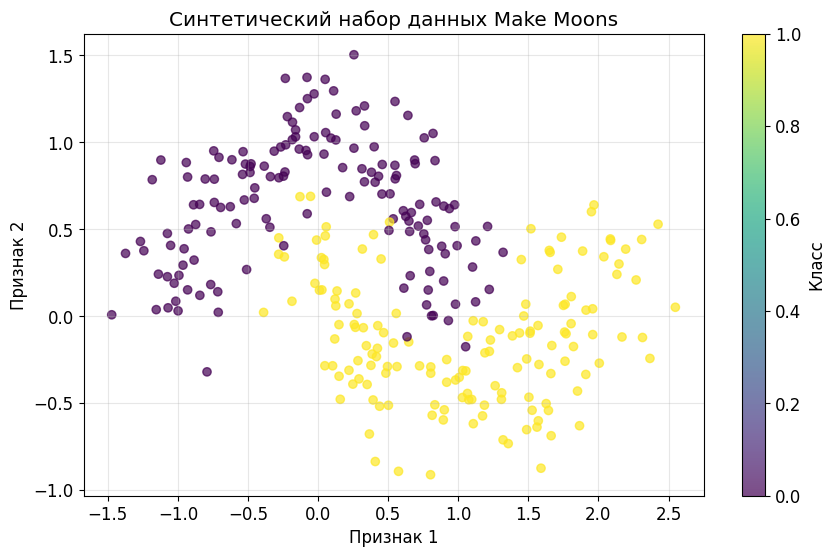

Данные успешно созданы и визуализированы!


In [ ]:
# Генерация синтетического набора данных make_moons
np.random.seed(42)

# Создание данных make_moons
X, y = make_moons(n_samples=300, noise=0.2, random_state=42)

# Преобразование данных в нужный формат
X = X.T  # Транспонируем для формата (n_features, m_examples)
y = y.reshape(1, -1)  # Форма (1, m_examples)

# Информация о данных
print(f"Форма X: {X.shape}")
print(f"Форма y: {y.shape}")
print(f"Количество примеров: {X.shape[1]}")
print(f"Количество признаков: {X.shape[0]}")
print(f"Уникальные классы: {np.unique(y)}")

# Визуализация данных
plt.figure(figsize=(10, 6))
plt.scatter(X[0, :], X[1, :], c=y[0, :], cmap='viridis', alpha=0.7)
plt.title('Синтетический набор данных Make Moons')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.colorbar(label='Класс')
plt.grid(True, alpha=0.3)
plt.show()

print("Данные успешно созданы и визуализированы!")

In [ ]:
# Создание и обучение нейронной сети

# Определение архитектуры сети
# [input_size, hidden1_size, hidden2_size, output_size]
layer_sizes = [2, 10, 5, 1]  # 2 входа, 2 скрытых слоя (10 и 5 нейронов), 1 выход

print("Создание нейронной сети...")
print(f"Архитектура сети: {layer_sizes}")

# Создание экземпляра сети
nn = NeuralNetwork(
    layer_sizes=layer_sizes,
    activation='relu',
    learning_rate=0.1,
    random_state=42
)

print("\nНачало обучения...")
print("=" * 50)

# Обучение сети
nn.fit(
    X_train=X,
    Y_train=y,
    epochs=2000,
    batch_size=32,
    print_cost=True,
    print_every=200
)

print("\nОбучение завершено!")
print("=" * 50)

Создание нейронной сети...
Архитектура сети: [2, 10, 5, 1]

Начало обучения...
Эпоха 0/2000, Средняя функция потерь: 0.662190
Эпоха 200/2000, Средняя функция потерь: 0.082742
Эпоха 400/2000, Средняя функция потерь: 0.069736
Эпоха 600/2000, Средняя функция потерь: 0.067468
Эпоха 800/2000, Средняя функция потерь: 0.068627
Эпоха 1000/2000, Средняя функция потерь: 0.067091
Эпоха 1200/2000, Средняя функция потерь: 0.060400
Эпоха 1400/2000, Средняя функция потерь: 0.073562
Эпоха 1600/2000, Средняя функция потерь: 0.056106
Эпоха 1800/2000, Средняя функция потерь: 0.066676

Обучение завершено!


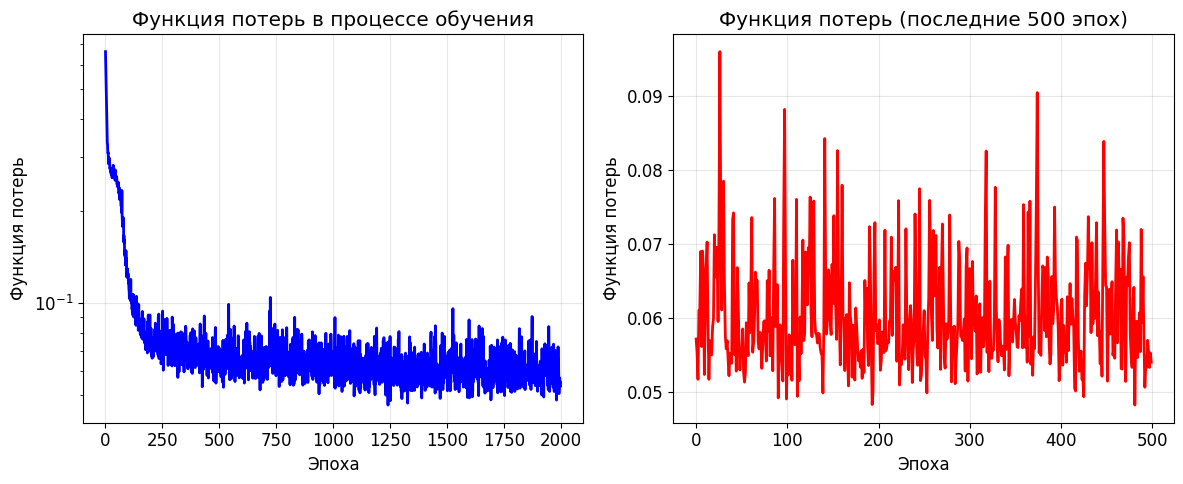


Финальное значение функции потерь: 0.054038


In [ ]:
# Визуализация функции потерь в процессе обучения
plt.figure(figsize=(12, 5))

# График функции потерь
plt.subplot(1, 2, 1)
plt.plot(nn.cost_history, 'b-', linewidth=2)
plt.title('Функция потерь в процессе обучения')
plt.xlabel('Эпоха')
plt.ylabel('Функция потерь')
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Логарифмическая шкала для лучшей визуализации

# График функции потерь (последние 500 эпох)
plt.subplot(1, 2, 2)
if len(nn.cost_history) > 500:
    plt.plot(nn.cost_history[-500:], 'r-', linewidth=2)
    plt.title('Функция потерь (последние 500 эпох)')
else:
    plt.plot(nn.cost_history, 'r-', linewidth=2)
    plt.title('Функция потерь (все эпохи)')
plt.xlabel('Эпоха')
plt.ylabel('Функция потерь')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Финальное значение функции потерь
final_cost = nn.cost_history[-1]
print(f"\nФинальное значение функции потерь: {final_cost:.6f}")

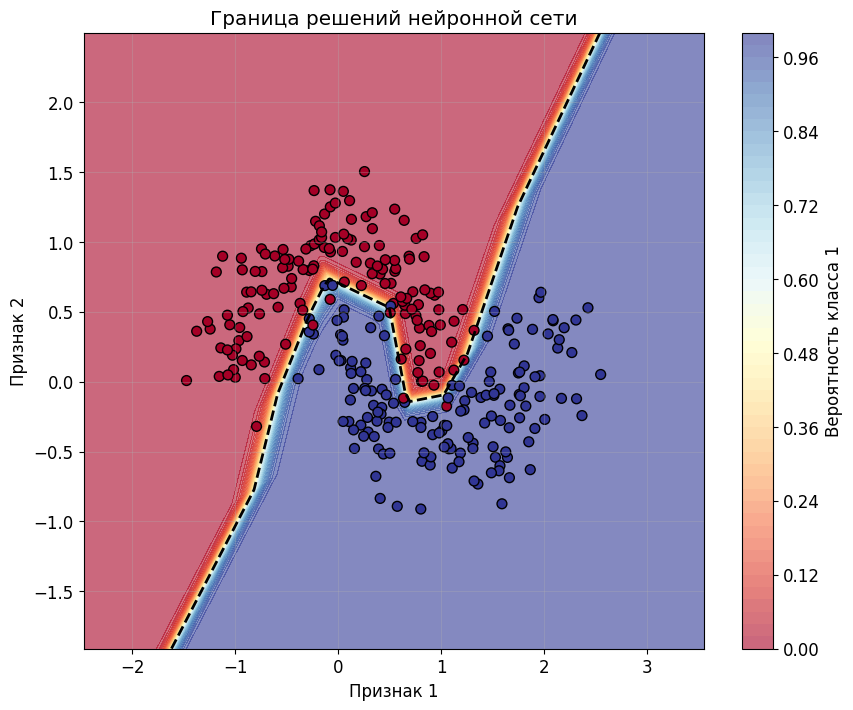

Граница решений построена!


In [ ]:
# Функция для визуализации границы решений
def plot_decision_boundary(X, y, model, title="Граница решений"):
    """
    Визуализация границы решений нейронной сети
    """
    plt.figure(figsize=(10, 8))

    # Создание сетки точек
    h = 0.01
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Создание входных данных для предсказания
    grid_points = np.c_[xx.ravel(), yy.ravel()].T

    # Предсказания для сетки
    _, probabilities = model.predict(grid_points)
    probabilities = probabilities.reshape(xx.shape)

    # Построение контурной карты
    plt.contourf(xx, yy, probabilities, levels=50, alpha=0.6, cmap='RdYlBu')
    plt.colorbar(label='Вероятность класса 1')

    # Добавление границы решений
    plt.contour(xx, yy, probabilities, levels=[0.5], colors='black', linewidths=2, linestyles='--')

    # Нанесение исходных точек данных
    scatter = plt.scatter(X[0, :], X[1, :], c=y[0, :], cmap='RdYlBu', edgecolors='black', s=50)

    plt.title(title)
    plt.xlabel('Признак 1')
    plt.ylabel('Признак 2')
    plt.grid(True, alpha=0.3)

    return plt

# Визуализация границы решений
plot_decision_boundary(X, y, nn, "Граница решений нейронной сети")
plt.show()

print("Граница решений построена!")

РЕЗУЛЬТАТЫ ОБУЧЕНИЯ НЕЙРОННОЙ СЕТИ
Архитектура сети: [2, 10, 5, 1]
Функция активации: relu
Скорость обучения: 0.1
Количество эпох: 2000
Финальная функция потерь: 0.054038
Точность на обучающих данных: 98.00%

Дополнительная статистика:
Количество правильных предсказаний: 294/300
Количество неправильных предсказаний: 6/300
Средняя вероятность для класса 0: 0.0448
Средняя вероятность для класса 1: 0.9787


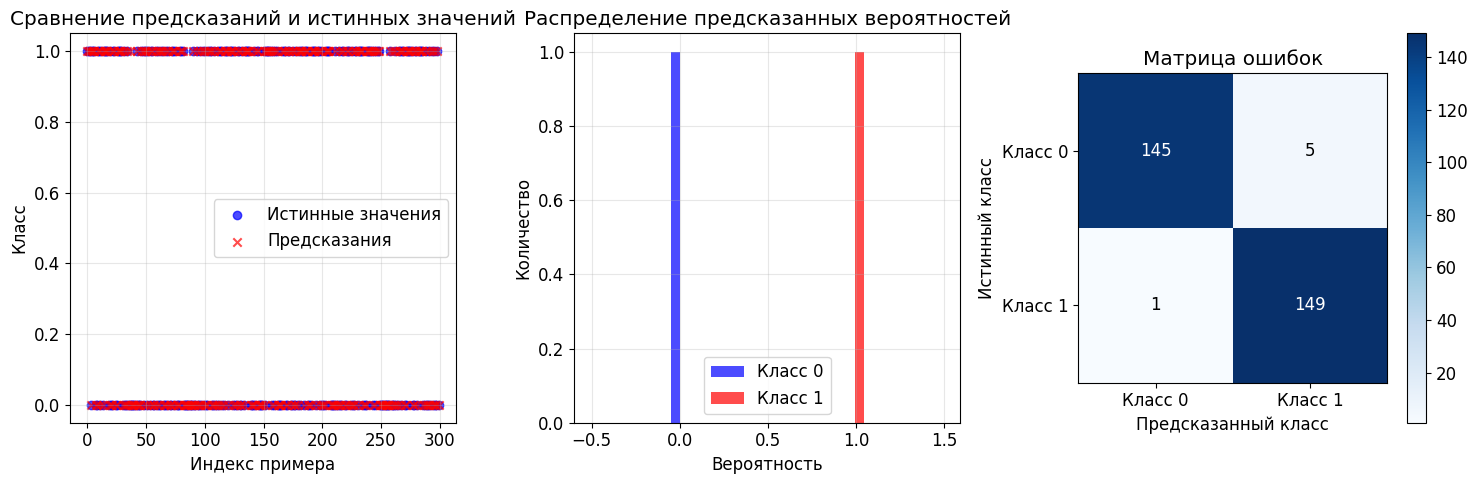

In [ ]:
# Оценка качества модели

# Получение предсказаний и вероятностей
predictions, probabilities = nn.predict(X)

# Вычисление точности
accuracy = nn.accuracy(X, y)

print("=" * 60)
print("РЕЗУЛЬТАТЫ ОБУЧЕНИЯ НЕЙРОННОЙ СЕТИ")
print("=" * 60)
print(f"Архитектура сети: {layer_sizes}")
print(f"Функция активации: {nn.activation}")
print(f"Скорость обучения: {nn.learning_rate}")
print(f"Количество эпох: {len(nn.cost_history)}")
print(f"Финальная функция потерь: {nn.cost_history[-1]:.6f}")
print(f"Точность на обучающих данных: {accuracy:.2f}%")
print("=" * 60)

# Дополнительная статистика
print("\nДополнительная статистика:")
print(f"Количество правильных предсказаний: {np.sum(predictions == y)}/{y.shape[1]}")
print(f"Количество неправильных предсказаний: {np.sum(predictions != y)}/{y.shape[1]}")
print(f"Средняя вероятность для класса 0: {np.mean(probabilities[y == 0]):.4f}")
print(f"Средняя вероятность для класса 1: {np.mean(probabilities[y == 1]):.4f}")

# Визуализация предсказаний vs истинных значений
plt.figure(figsize=(15, 5))

# График 1: Сравнение предсказаний и истинных значений
plt.subplot(1, 3, 1)
plt.scatter(range(len(y[0])), y[0], alpha=0.7, label='Истинные значения', color='blue')
plt.scatter(range(len(predictions[0])), predictions[0], alpha=0.7, label='Предсказания', color='red', marker='x')
plt.title('Сравнение предсказаний и истинных значений')
plt.xlabel('Индекс примера')
plt.ylabel('Класс')
plt.legend()
plt.grid(True, alpha=0.3)

# График 2: Распределение вероятностей по классам
plt.subplot(1, 3, 2)
plt.hist(probabilities[y == 0][0], bins=20, alpha=0.7, label='Класс 0', color='blue')
plt.hist(probabilities[y == 1][0], bins=20, alpha=0.7, label='Класс 1', color='red')
plt.title('Распределение предсказанных вероятностей')
plt.xlabel('Вероятность')
plt.ylabel('Количество')
plt.legend()
plt.grid(True, alpha=0.3)

# График 3: Матрица ошибок (Confusion Matrix)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y[0], predictions[0])

plt.subplot(1, 3, 3)
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Матрица ошибок')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Класс 0', 'Класс 1'])
plt.yticks(tick_marks, ['Класс 0', 'Класс 1'])
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')

# Добавление значений в ячейки матрицы
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="white" if cm[i, j] > cm.max()/2 else "black")

plt.tight_layout()
plt.show()

## Эксперименты с архитектурой сети и гиперпараметрами

В этом разделе мы можем поэкспериментировать с различными параметрами сети:

### 1. Изменение архитектуры сети
- Количество скрытых слоев
- Количество нейронов в каждом слое

### 2. Изменение функций активации
- ReLU vs Sigmoid vs Tanh

### 3. Изменение гиперпараметров
- Скорость обучения (learning_rate)
- Размер мини-батча (batch_size)
- Количество эпох обучения

### 4. Тестирование на других наборах данных
- make_circles
- make_blobs
- Собственные синтетические данные


Обучение Малая сеть: [2, 5, 1]

Обучение Средняя сеть: [2, 10, 5, 1]

Обучение Большая сеть: [2, 20, 10, 5, 1]

Обучение Очень широкая: [2, 50, 1]


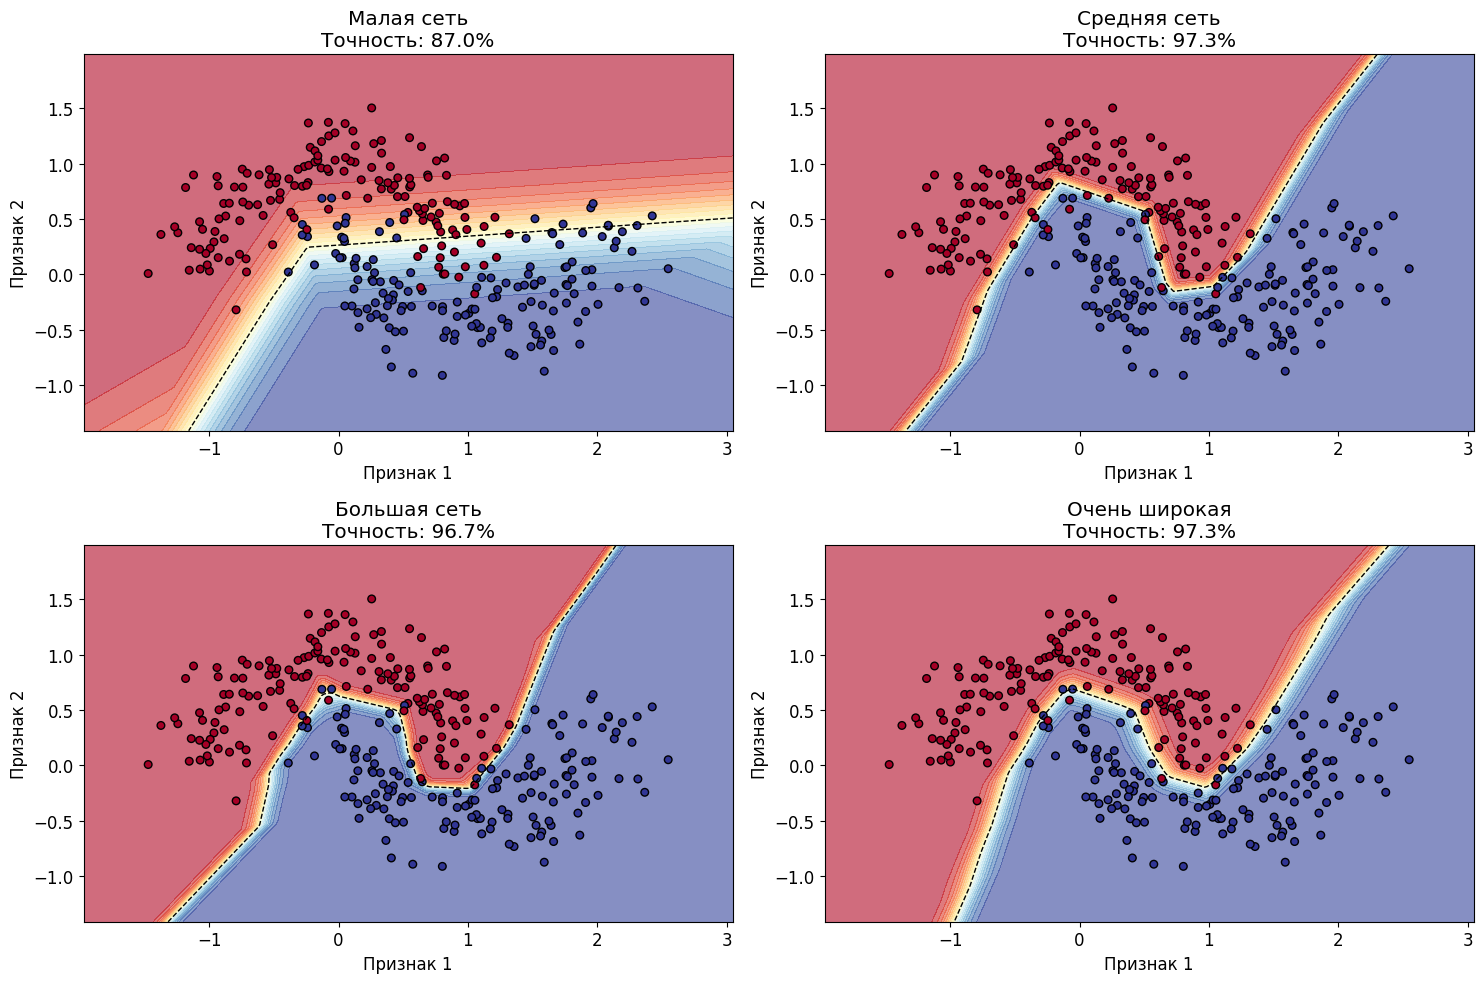


РЕЗУЛЬТАТЫ СРАВНЕНИЯ АРХИТЕКТУР
Малая сеть     : Архитектура [2, 5, 1]       | Точность:  87.00% | Финальная потеря: 0.277061
Средняя сеть   : Архитектура [2, 10, 5, 1]   | Точность:  97.33% | Финальная потеря: 0.065151
Большая сеть   : Архитектура [2, 20, 10, 5, 1] | Точность:  96.67% | Финальная потеря: 0.066461
Очень широкая  : Архитектура [2, 50, 1]      | Точность:  97.33% | Финальная потеря: 0.067035


In [ ]:
# Эксперимент 1: Сравнение различных архитектур сети

def experiment_architectures():
    """Сравнение различных архитектур нейронной сети"""

    architectures = {
        'Малая сеть': [2, 5, 1],
        'Средняя сеть': [2, 10, 5, 1],
        'Большая сеть': [2, 20, 10, 5, 1],
        'Очень широкая': [2, 50, 1]
    }

    results = {}

    plt.figure(figsize=(15, 10))

    for i, (name, architecture) in enumerate(architectures.items()):
        print(f"\nОбучение {name}: {architecture}")

        # Создание и обучение сети
        nn_exp = NeuralNetwork(
            layer_sizes=architecture,
            activation='relu',
            learning_rate=0.1,
            random_state=42
        )

        nn_exp.fit(X, y, epochs=1000, batch_size=32, print_cost=False)

        # Сохранение результатов
        accuracy = nn_exp.accuracy(X, y)
        results[name] = {
            'accuracy': accuracy,
            'final_cost': nn_exp.cost_history[-1],
            'architecture': architecture
        }

        # Визуализация границы решений
        plt.subplot(2, 2, i+1)

        # Упрощенная версия plot_decision_boundary для подграфиков
        h = 0.02
        x_min, x_max = X[0, :].min() - 0.5, X[0, :].max() + 0.5
        y_min, y_max = X[1, :].min() - 0.5, X[1, :].max() + 0.5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))

        grid_points = np.c_[xx.ravel(), yy.ravel()].T
        _, probabilities = nn_exp.predict(grid_points)
        probabilities = probabilities.reshape(xx.shape)

        plt.contourf(xx, yy, probabilities, levels=20, alpha=0.6, cmap='RdYlBu')
        plt.contour(xx, yy, probabilities, levels=[0.5], colors='black', linewidths=1, linestyles='--')
        plt.scatter(X[0, :], X[1, :], c=y[0, :], cmap='RdYlBu', edgecolors='black', s=30)

        plt.title(f'{name}\nТочность: {accuracy:.1f}%')
        plt.xlabel('Признак 1')
        plt.ylabel('Признак 2')

    plt.tight_layout()
    plt.show()

    # Вывод результатов
    print("\n" + "="*70)
    print("РЕЗУЛЬТАТЫ СРАВНЕНИЯ АРХИТЕКТУР")
    print("="*70)
    for name, result in results.items():
        print(f"{name:15s}: Архитектура {str(result['architecture']):15s} | "
              f"Точность: {result['accuracy']:6.2f}% | "
              f"Финальная потеря: {result['final_cost']:8.6f}")

    return results

# Запуск эксперимента
arch_results = experiment_architectures()


Обучение с функцией активации: relu

Обучение с функцией активации: sigmoid

Обучение с функцией активации: tanh


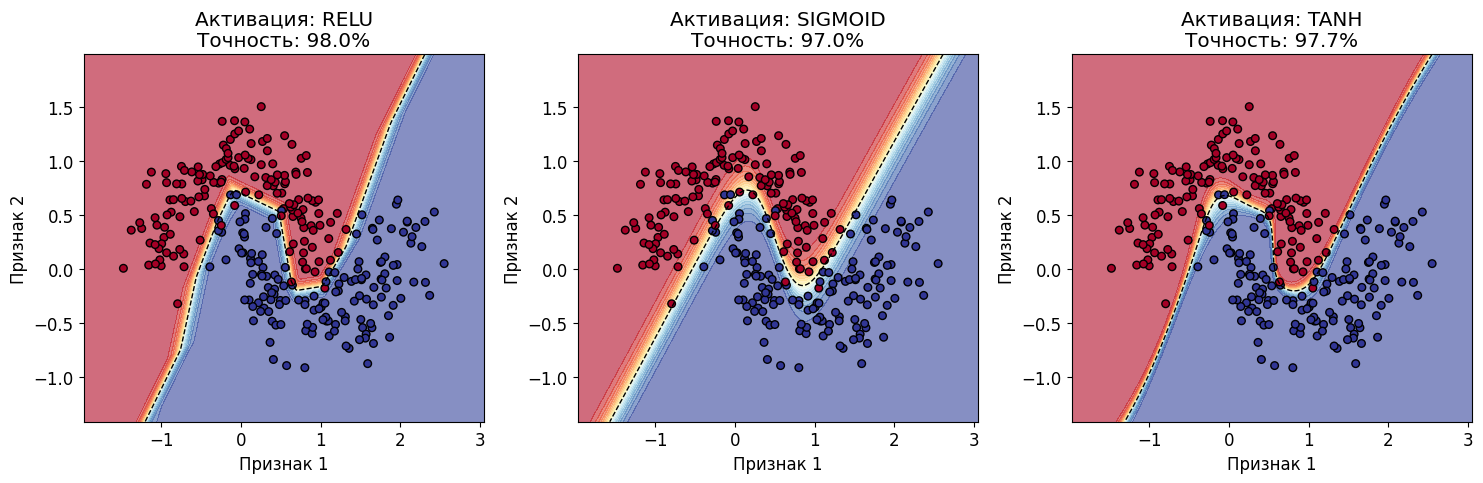

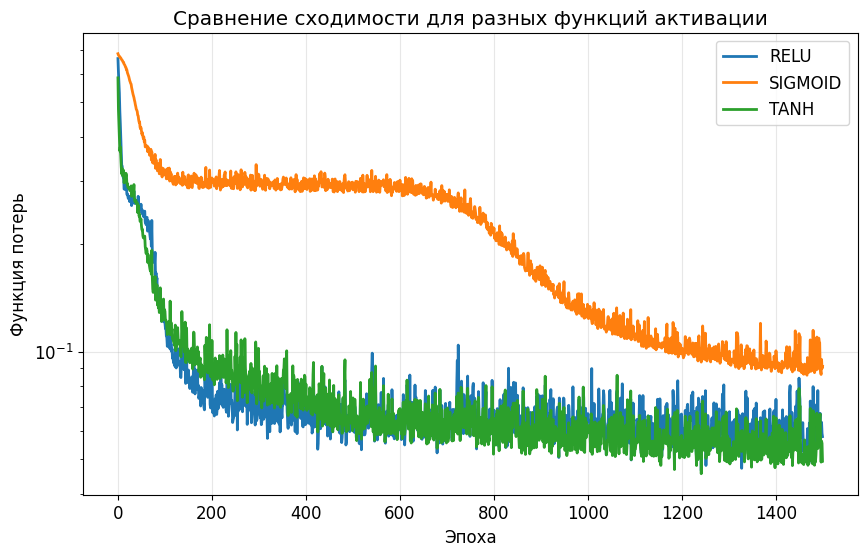


РЕЗУЛЬТАТЫ СРАВНЕНИЯ ФУНКЦИЙ АКТИВАЦИИ
RELU    : Точность:  98.00% | Финальная потеря: 0.057864
SIGMOID : Точность:  97.00% | Финальная потеря: 0.090991
TANH    : Точность:  97.67% | Финальная потеря: 0.049383


In [ ]:
# Эксперимент 2: Сравнение функций активации

def experiment_activations():
    """Сравнение различных функций активации"""

    activations = ['relu', 'sigmoid', 'tanh']
    results = {}

    plt.figure(figsize=(15, 5))

    for i, activation in enumerate(activations):
        print(f"\nОбучение с функцией активации: {activation}")

        # Создание и обучение сети
        nn_exp = NeuralNetwork(
            layer_sizes=[2, 10, 5, 1],
            activation=activation,
            learning_rate=0.1,
            random_state=42
        )

        nn_exp.fit(X, y, epochs=1500, batch_size=32, print_cost=False)

        # Сохранение результатов
        accuracy = nn_exp.accuracy(X, y)
        results[activation] = {
            'accuracy': accuracy,
            'final_cost': nn_exp.cost_history[-1],
            'cost_history': nn_exp.cost_history.copy()
        }

        # Визуализация границы решений
        plt.subplot(1, 3, i+1)

        h = 0.02
        x_min, x_max = X[0, :].min() - 0.5, X[0, :].max() + 0.5
        y_min, y_max = X[1, :].min() - 0.5, X[1, :].max() + 0.5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))

        grid_points = np.c_[xx.ravel(), yy.ravel()].T
        _, probabilities = nn_exp.predict(grid_points)
        probabilities = probabilities.reshape(xx.shape)

        plt.contourf(xx, yy, probabilities, levels=20, alpha=0.6, cmap='RdYlBu')
        plt.contour(xx, yy, probabilities, levels=[0.5], colors='black', linewidths=1, linestyles='--')
        plt.scatter(X[0, :], X[1, :], c=y[0, :], cmap='RdYlBu', edgecolors='black', s=30)

        plt.title(f'Активация: {activation.upper()}\nТочность: {accuracy:.1f}%')
        plt.xlabel('Признак 1')
        plt.ylabel('Признак 2')

    plt.tight_layout()
    plt.show()

    # График сравнения обучения
    plt.figure(figsize=(10, 6))
    for activation, result in results.items():
        plt.plot(result['cost_history'], label=f'{activation.upper()}', linewidth=2)

    plt.title('Сравнение сходимости для разных функций активации')
    plt.xlabel('Эпоха')
    plt.ylabel('Функция потерь')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    plt.show()

    # Вывод результатов
    print("\n" + "="*60)
    print("РЕЗУЛЬТАТЫ СРАВНЕНИЯ ФУНКЦИЙ АКТИВАЦИИ")
    print("="*60)
    for activation, result in results.items():
        print(f"{activation.upper():8s}: Точность: {result['accuracy']:6.2f}% | "
              f"Финальная потеря: {result['final_cost']:8.6f}")

    return results

# Запуск эксперимента
activation_results = experiment_activations()


Обучение на наборе данных: Make Moons

Обучение на наборе данных: Make Circles

Обучение на наборе данных: Make Blobs


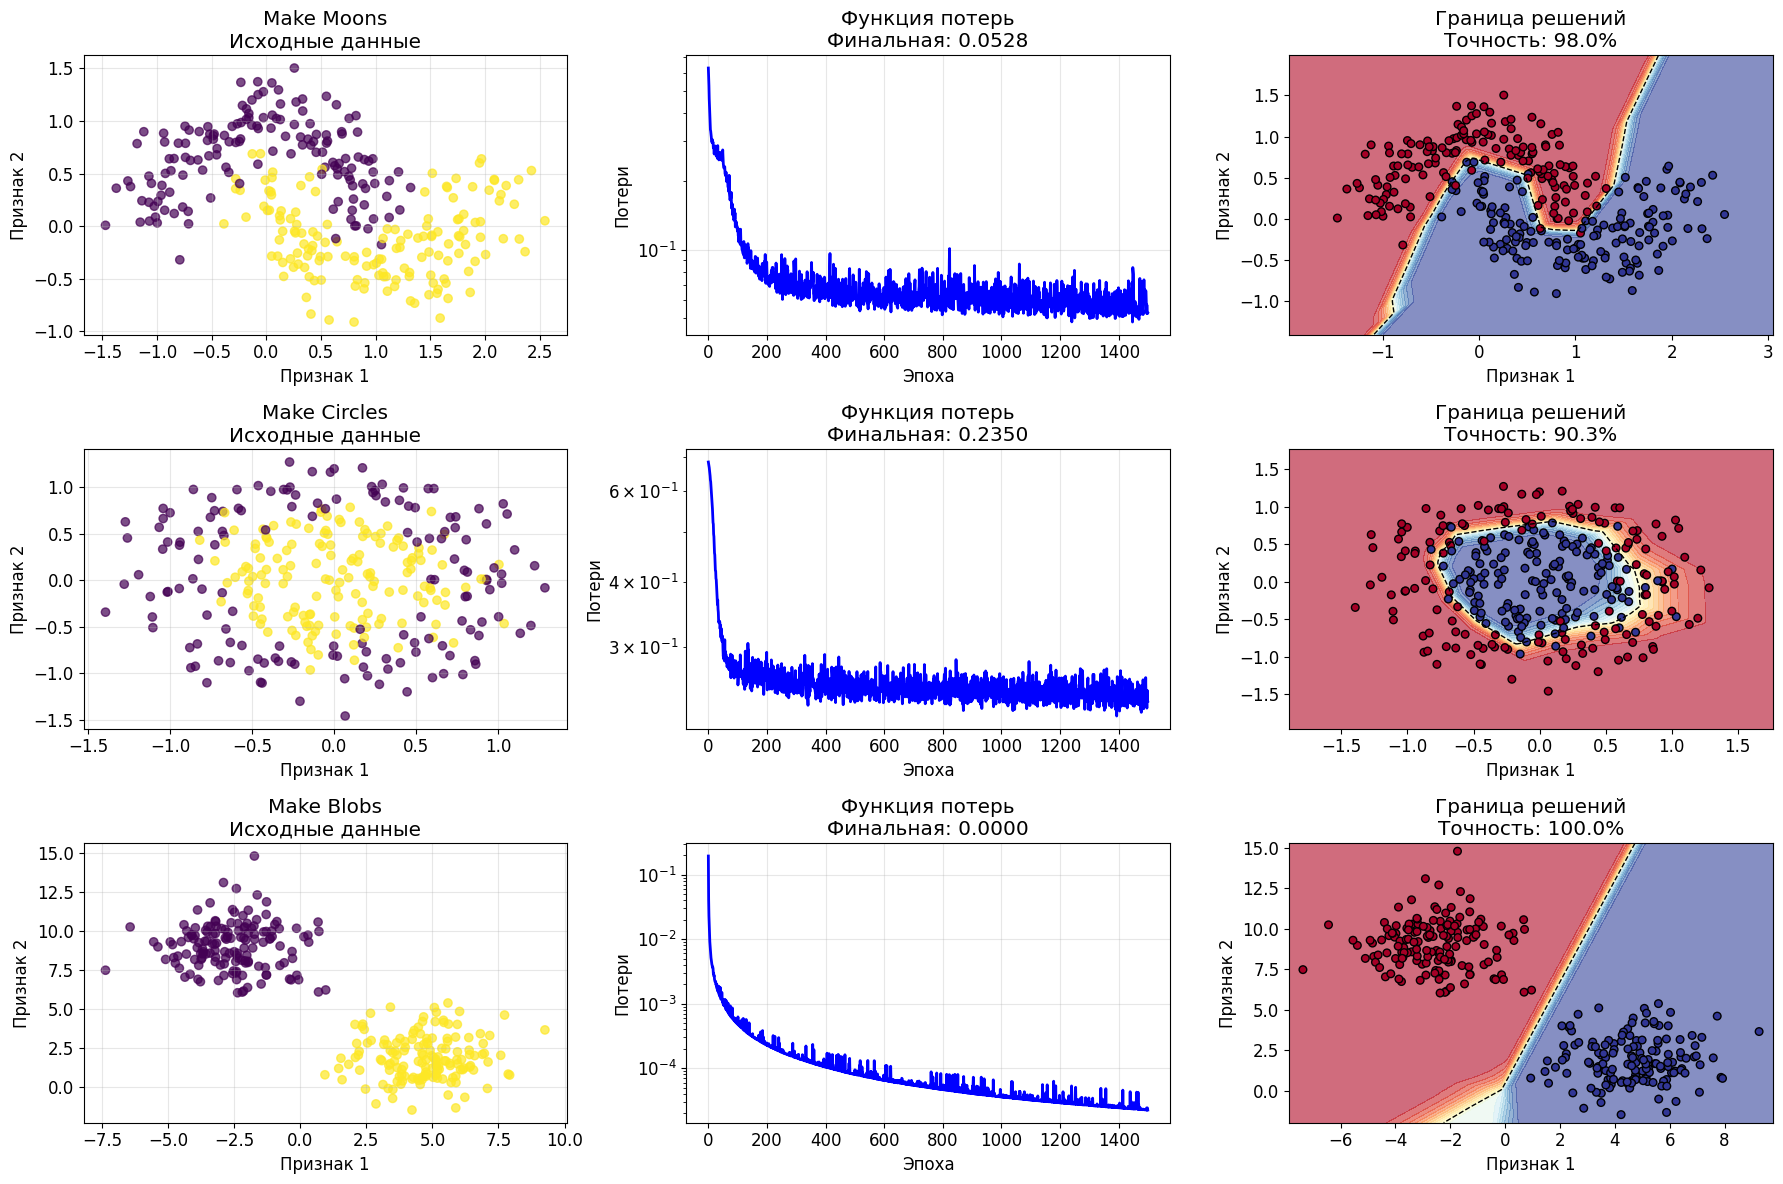


РЕЗУЛЬТАТЫ НА РАЗНЫХ НАБОРАХ ДАННЫХ
Make Moons  : Точность:  98.00% | Финальная потеря: 0.052837
Make Circles: Точность:  90.33% | Финальная потеря: 0.234999
Make Blobs  : Точность: 100.00% | Финальная потеря: 0.000023


In [ ]:
# Эксперимент 3: Тестирование на разных наборах данных

def experiment_datasets():
    """Тестирование нейронной сети на различных наборах данных"""

    # Создание различных наборов данных
    np.random.seed(42)

    datasets = {
        'Make Moons': make_moons(n_samples=300, noise=0.2, random_state=42),
        'Make Circles': make_circles(n_samples=300, noise=0.2, factor=0.5, random_state=42),
        'Make Blobs': make_blobs(n_samples=300, centers=2, n_features=2,
                                random_state=42, cluster_std=1.5)
    }

    results = {}

    plt.figure(figsize=(18, 12))

    for i, (name, (X_data, y_data)) in enumerate(datasets.items()):
        print(f"\nОбучение на наборе данных: {name}")

        # Подготовка данных
        X_data = X_data.T
        y_data = y_data.reshape(1, -1)

        # Создание и обучение сети
        nn_exp = NeuralNetwork(
            layer_sizes=[2, 15, 8, 1],
            activation='relu',
            learning_rate=0.1,
            random_state=42
        )

        nn_exp.fit(X_data, y_data, epochs=1500, batch_size=32, print_cost=False)

        # Сохранение результатов
        accuracy = nn_exp.accuracy(X_data, y_data)
        results[name] = {
            'accuracy': accuracy,
            'final_cost': nn_exp.cost_history[-1],
            'X': X_data,
            'y': y_data
        }

        # Визуализация исходных данных
        plt.subplot(3, 3, i*3 + 1)
        plt.scatter(X_data[0, :], X_data[1, :], c=y_data[0, :], cmap='viridis', alpha=0.7)
        plt.title(f'{name}\nИсходные данные')
        plt.xlabel('Признак 1')
        plt.ylabel('Признак 2')
        plt.grid(True, alpha=0.3)

        # Визуализация функции потерь
        plt.subplot(3, 3, i*3 + 2)
        plt.plot(nn_exp.cost_history, 'b-', linewidth=2)
        plt.title(f'Функция потерь\nФинальная: {nn_exp.cost_history[-1]:.4f}')
        plt.xlabel('Эпоха')
        plt.ylabel('Потери')
        plt.grid(True, alpha=0.3)
        plt.yscale('log')

        # Визуализация границы решений
        plt.subplot(3, 3, i*3 + 3)

        h = 0.02
        x_min, x_max = X_data[0, :].min() - 0.5, X_data[0, :].max() + 0.5
        y_min, y_max = X_data[1, :].min() - 0.5, X_data[1, :].max() + 0.5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))

        grid_points = np.c_[xx.ravel(), yy.ravel()].T
        _, probabilities = nn_exp.predict(grid_points)
        probabilities = probabilities.reshape(xx.shape)

        plt.contourf(xx, yy, probabilities, levels=20, alpha=0.6, cmap='RdYlBu')
        plt.contour(xx, yy, probabilities, levels=[0.5], colors='black', linewidths=1, linestyles='--')
        plt.scatter(X_data[0, :], X_data[1, :], c=y_data[0, :], cmap='RdYlBu', edgecolors='black', s=30)

        plt.title(f'Граница решений\nТочность: {accuracy:.1f}%')
        plt.xlabel('Признак 1')
        plt.ylabel('Признак 2')

    plt.tight_layout()
    plt.show()

    # Вывод результатов
    print("\n" + "="*60)
    print("РЕЗУЛЬТАТЫ НА РАЗНЫХ НАБОРАХ ДАННЫХ")
    print("="*60)
    for name, result in results.items():
        print(f"{name:12s}: Точность: {result['accuracy']:6.2f}% | "
              f"Финальная потеря: {result['final_cost']:8.6f}")

    return results

# Запуск эксперимента
dataset_results = experiment_datasets()